## Requirements
### 1. Stochatic Environment
Pricing algorithm: Build a pricing strategy using the continuous set of prices p ∈ [0, 1] and Gaussian Processes.
Bidding algorithm: Consider a sequence of second-price auctions. Build two learning algorithms to deal with the bidding problem:
- primal-dual algorithm for truthful auctions
- UCB-like algorithm
### 2. Adversarial Environment
Build an highly non-stationary environment. At an high level, it should include:
- A sequence of competing bids of the other agents (e.g., sampled from a distribution that changes quickly over time)
- For each day, a function specifying the probability with which an user buys for every price (this function changes quickly over time)

Build a pricing strategy discretizing the continuous set of prices p ∈ [0, 1]
Consider a generalized first-price auction. Build a learning algorithms to deal with the bidding problem. In particular, a primal-dual algorithm for non-truthful auctions.
### 3. two extensions for pricing - BONUS IS NOT INCLUDED HERE
We extend the pricing problem along two directions. Since we focus only on pricing, we directly consider a demand curve with noise (differently from previous points in which the demand curve depends on the number of visits and hence on the advertising step).

Build a pricing strategy using the discretization of the prices p ∈ [0, 1] and:
1. sliding-window
2. CUSUM

Build a non-stationary environment for the pricing problem. At an high level:
- Days are partitioned in intervals
- In each interval the demand curve is different
- The demand curve + noise specifies how many buyers while buy for every price depending on the current interval

### 4. Comparing Different Bidding Algorithms
The goal is to compare the performances of different algorithms.
Consider the different algorithms that we have seen for bidding and let them play one against the others in a generalized first-price auction. In particular, consider:
- A primal-dual algorithm for truthful auctions
- A primal-dual algorithm for non-truthful auctions
- A UCB-like approach


# Codes

# Stochatic Environment

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, RationalQuadratic, ExpSineSquared, Matern
import matplotlib.pyplot as plt
from scipy.stats import norm 

## Stochastic Pricing Environment

Environment considers the continuous set of prices, takes as initialization parameters :
- cost
- max price
- noise level
- family of conversion probability of sale basing on price

and in order to output a sample of demand and profit, requires as time-variant parameters:
- price established at time t  (price_t ∈ [0, 1])
- number of customers at time t


In [ ]:
class StochasticPricingEnvironment:
    def __init__(self, cost, max_price=1.0, noise_level=0., model='linear', alpha=None, beta=None):
        self.cost = cost
        self.max_price = max_price
        self.noise_level = noise_level
        self.conversion_probability = StochasticPricingEnvironment.generate_probability(model, alpha, beta)
        np.random.seed(42)

    # given settled price and number customer
    # returns a sample of number of sale and profit
    def round(self, price_t, n_costumer_t):
        # number of sale at time t
        number_sale_t = np.random.binomial(n_costumer_t, self.conversion_probability(price_t))

        # noise to the number of sale
        number_sale_t += int(np.random.normal(0, self.noise_level * n_costumer_t))

        # profit at time t
        profit_t = (price_t - self.cost)*number_sale_t

        return number_sale_t, profit_t

    # return a probability function that 
    # takes as input the selling price
    # return as output the probability of selling 
    @staticmethod
    def generate_probability(model, a, b, price):
        def isNotNone(s,d):
            if s is None:
                return d
            else:
                return s
        
        if model == 'linear':
            alpha = isNotNone(a, 1) # Intercept
            beta = isNotNone(b, -1)  # Slope
            purchase_probabilities = alpha + beta * price
            
        elif model == 'logit':
            alpha = isNotNone(a, 0)
            beta = isNotNone(b, -5)
            purchase_probabilities = 1 / (1 + np.exp(-(alpha + beta * price)))
            
        elif model == 'probit':
            alpha = isNotNone(a, 0)
            beta = isNotNone(b, -5)
            purchase_probabilities = norm.cdf(alpha + beta * price)
            
        elif model == 'KERNEL':
            purchase_probabilities = np.abs(np.sin(2 * np.pi * price) * np.exp(-price * 5) + price * .10) + .1

        return purchase_probabilities


## Gaussian Process Agent
At each round (day or a couple of hours), the agent decides:
- a price (our choice, from continuous set [0,1])
- the number of visiting customer (depending on advertising campaign)

Gets feedback (a realization) from environment and then updates its internal state -> gaussian process



#### Radial Basis Function Kernel

In [ ]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

#### Other types of kernels
TO-DO

#### Gaussian Process Agent with RBF kernel and UCB algorithm

In [ ]:
# From the agent's point of view, action set is [0,1]. If the actual actions are outside this
# set, we can always perform a rescaling outside the class.
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        #    averages of GP  +  estimation uncertainty
        ucbs = self.mu_t + self.beta(self.t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

#### Gaussian Process Agent with RBF kernel and Thompson Sampling algorithm
TO-DO

In [ ]:
# From the agent's point of view, action set is [0,1]. If the actual actions are outside this
# set, we can always perform a rescaling outside the class.
class GPTSAgent:
    def __init__(self, T, discretization=100):
        pass

    def pull_arm(self):
        pass
    
    def update(self, r_t):
        pass

## Bidding Algos
Consider a sequence of **second-price auctions**. Build two learning algorithms to deal
with the bidding problem:

### Primal-Dual Algo
The primal-dual approach can be used to adjust bids based on historical auction outcomes to learn the optimal bidding strategy over time.
- Primal problem: Maximize your utility, considering your valuation of the item minus the cost (if you win the auction).
- Dual problem: Learn the distribution of other bids to minimize the difference between your bid and the winning bid, ensuring you don't overpay.  **(no need of this as we are in truthful auctions -> Second price or VCG, we pay lower than our bid)**
- *maybe not to minimize the difference between bids, but to decrease the probability to putting high bids that even if won, does not bring a big utility, instead consume the budget available for future auctions .*
- *or to bid more aggressively in order to win as many auctions as possible always within the budget, because as shown in professor's notebook, most of time, the budget does not deplet after all auctions (all costumers) .*

The algorithm iteratively updates bids based on past auction results, aiming to find a balance between winning auctions (primal) and minimizing payment (dual).

### UCB-like Algo
Designed for exploration and exploitation in uncertain environments. Applied to bidding, it could estimate the optimal bid by balancing:

- Exploration: Trying different rhos ranging from Budget/Number_Round to Agent_Valuation to learn the expected feedback with different lambdas derived by rhos
- Exploitation: Using the acquired knowledge to bid more strategically based on the estimated optimal rhos.


### second price auctions

In [1]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass
    def get_winners(self, bids):
        pass
    def get_payments_per_click(self, winners, values, bids):
        pass
    def round(self, bids):
        # given bids, return winner(s) and the estimated values (product of 3 terms : lambda, q, bid) of winner(s)
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

class SecondPriceAuction(Auction):
    def __init__(self, ctrs):
        # ctr = click though rate = lambda * q
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        # sort not by bids, but estimated values
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        payment = values[second]/self.ctrs[winners]
        return payment.round(2)

In [122]:
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    #   if valuation less than max_bid of the round, no need to participate
    #   if higher, utility is the difference

    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0
    i = 0
    #    (enough budget) and (examined all rounds)
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = 1  # simply bid 1 because we are in second-price auction
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]  # cost is incremented by second price of that round
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

### bidding agents
- fixed bidding
- multiplicative pacing
- multiplicatiev pacing with continuously updated rho (**best so far**)

In [14]:
class FixedBiddingAgent:
    def __init__(self, initial_bid=0.5):
        self.current_bid = initial_bid

    def bid(self):
        # For now, it returns a fixed or randomly chosen bid.
        return self.current_bid

    def update(self, auction_result, cost=None):
        # Placeholder for a learning mechanism to adjust bids over time.
        pass

In [70]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta # learning rate
        self.T = T
        self.rho = 1.*self.budget/self.T
        self.lmbd = 1  # shouldn't this be initialized with 0?
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

In [79]:
class ContinuousUpdatedRhoMPAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta # learning rate
        self.T = T
        self.rho = 1.*self.budget/self.T
        self.lmbd = 1  # shouldn't this be initialized with 0?
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t):
        self.t += 1
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t
        if(self.t<self.T):
            self.rho = self.budget/(self.T-self.t)

### FFMultiplicativePacingAgent attempt

In [86]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1
        
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]
    
    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

In [87]:
# simulation
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats

# environmental settings
n_rounds= 1000

# opponents' fixed parameters
n_adv = 4 # four opponents
ctrs = np.ones(n_adv).tolist()
# v = [0.7, 1.1, 1.4, 0.85]

# my parameters
my_value = 0.8
my_ctr = 1
B = n_rounds*my_value/10 # 80
# v.append(my_value)
ctrs.append(my_ctr)


np.random.seed(18)
# simple scenario: competitors sample bids from a uniform 
other_bids = np.random.uniform(0, 1, size = (n_adv, n_rounds))
# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.
m_t = other_bids.max(axis=0)

### the maximum among k uniformly distributed r.v.s is a beta r.v. with alpha=k and beta=1
number_rhos = np.linspace(0,1,11)
win_probabilities = stats.beta.cdf(number_rhos, n_adv, 1)

eta = 1/np.sqrt(n_rounds) # from theory
agent = FFMultiplicativePacingAgent(bids_set = number_rhos, 
                                    valuation=my_value,
                                    budget=B,
                                    T=n_rounds, 
                                    eta=eta)


auction = SecondPriceAuction(ctrs)

utilities = []
my_bids = []
my_payments = []
total_wins = 0

np.random.seed(1)
for u in range(n_rounds):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_value-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    if(my_win):
        print(f'# Round {u}')
        print(f'my bid = {my_bid}, left budget={agent.budget}')
    utilities.append(f_t)
    my_bids.append(my_bid)
    my_payments.append(c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')


# Round 9
my bid = 0.5, left budget=79.55159093144019
# Round 13
my bid = 0.9, left budget=78.6722740408238
# Round 20
my bid = 0.8, left budget=77.9726184118317
# Round 21
my bid = 1.0, left budget=77.43920130741641
# Round 32
my bid = 1.0, left budget=76.55722399110311
# Round 34
my bid = 0.7000000000000001, left budget=75.86869951691752
# Round 39
my bid = 0.8, left budget=75.29617160355453
# Round 40
my bid = 1.0, left budget=74.93174370995382
# Round 43
my bid = 0.8, left budget=74.32717752231201
# Round 47
my bid = 0.30000000000000004, left budget=74.10157688435878
# Round 58
my bid = 0.6000000000000001, left budget=73.50807803877753
# Round 59
my bid = 0.7000000000000001, left budget=72.86945382198657
# Round 67
my bid = 0.5, left budget=72.42797768824434
# Round 68
my bid = 1.0, left budget=71.48378132629195
# Round 76
my bid = 0.9, left budget=70.64228624747803
# Round 80
my bid = 0.9, left budget=70.03692854349286
# Round 85
my bid = 0.9, left budget=69.24965853036498
# Round

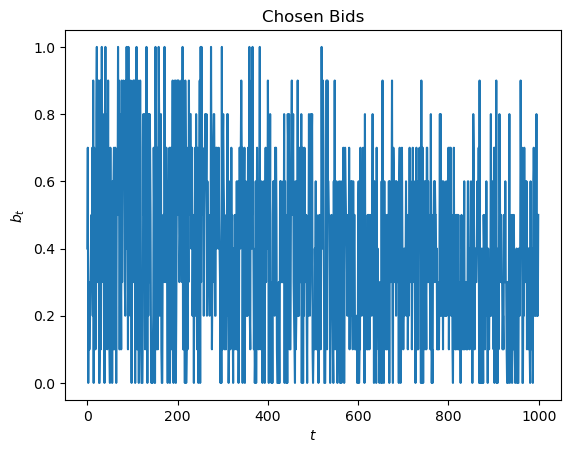

In [88]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

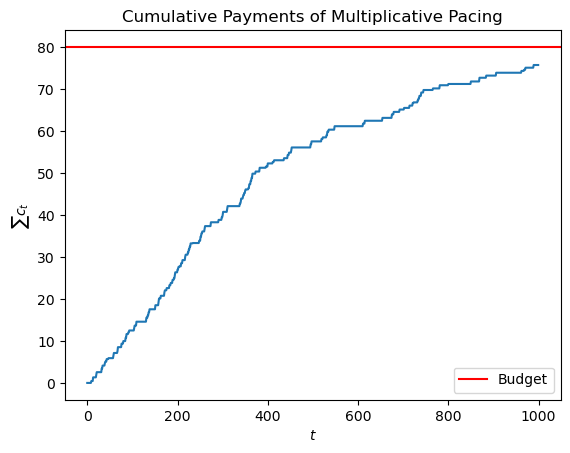

In [89]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

### UCB like approach

In [94]:
class UCBMultiPaceAgent:
    def __init__(self, valuation, budget, T, eta, number_rhos, range=1):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta # learning rate
        self.T = T
        self.range = range
        self.used_rho = None
        self.number_rhos = number_rhos
        self.average_rewards = np.zeros(number_rhos)
        self.N_pulls = np.zeros(number_rhos)
        self.rhos = np.linspace(budget/T, valuation, number_rhos)
        self.lmbds = np.ones(number_rhos)
        self.t = 0

    def bid(self):
        # play every arm once
        if self.t < self.number_rhos:
            self.used_rho = self.t 
        else:
            # compute UCB for every arms, choose arm with highest UCB
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.used_rho = np.argmax(ucbs)
    
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbds[self.used_rho]+1)
    
    def update(self, f_t, c_t):
        self.N_pulls[self.used_rho] += 1
        # update only used rho's average reward
        self.average_rewards[self.used_rho] += (f_t - self.average_rewards[self.used_rho])/self.N_pulls[self.used_rho]
        # update all rhos's lmbd according to c_t and their rho value
        self.lmbds = np.clip(self.lmbds-self.eta*(self.rhos-c_t), 
                            a_min=0, a_max=1/self.rhos)
        self.budget -= c_t
        self.t += 1

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import math

# environmental settings
n_rounds= 100000

# opponents' fixed parameters
n_adv = 4 # four opponents
ctrs = np.ones(n_adv).tolist()
# v = [0.7, 1.1, 1.4, 0.85]

# my parameters
my_value = 0.8
my_ctr = 1
B = n_rounds*my_value/10 # 80
# v.append(my_value)
ctrs.append(my_ctr)
number_rhos = 10

# UCB multiplicative pace agent
eta = 1/math.sqrt(n_rounds) # from theory
my_agent = UCBMultiPaceAgent(valuation=my_value,
                                  budget=B,
                                  T=n_rounds, 
                                  eta=eta,
                                  number_rhos=number_rhos)

auction = SecondPriceAuction(ctrs)

utilities = []
my_bids = []
my_payments = []
total_wins = 0

np.random.seed(18)
for u in range(n_rounds):
    # interaction
    my_bid = round(my_agent.bid(),2)
    # bids = np.append(np.random.choice([0.25, 0.5, 0.75, 1], size=n_adv), my_bid)
    bids = np.append(np.random.uniform(0, 1, size=n_adv), my_bid)
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==n_adv)
    f_t, c_t = (my_value-payments_per_click)*my_win, payments_per_click*my_win
    my_agent.update(f_t, c_t)
    # logging
    # if(my_win):
    # print(f'# Round {u}')
    # print(f'chosen rho={my_agent.used_rho}, my bid = {my_bid}, left budget={my_agent.budget}, lambda={my_agent.lmbds}')

    utilities.append(f_t)
    my_bids.append(my_bid)
    my_payments.append(c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')


Total # of Wins: 12621


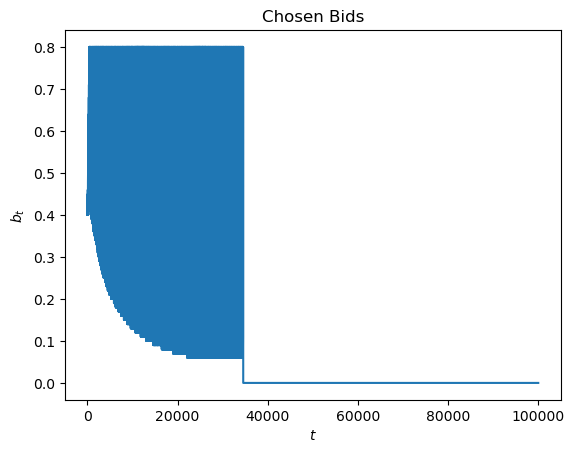

In [116]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

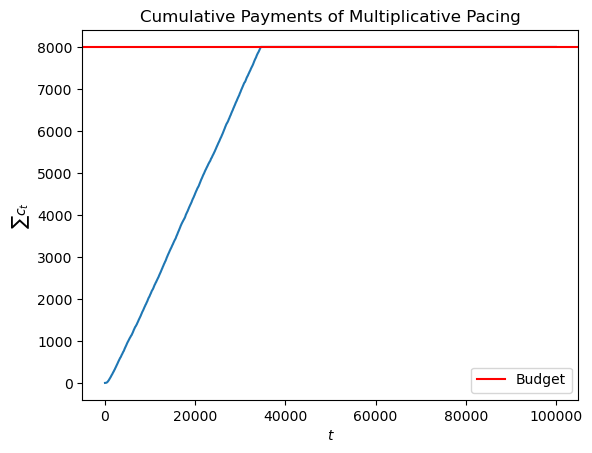

In [117]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

Text(0.5, 1.0, 'number of pulls per arm of UCB1')

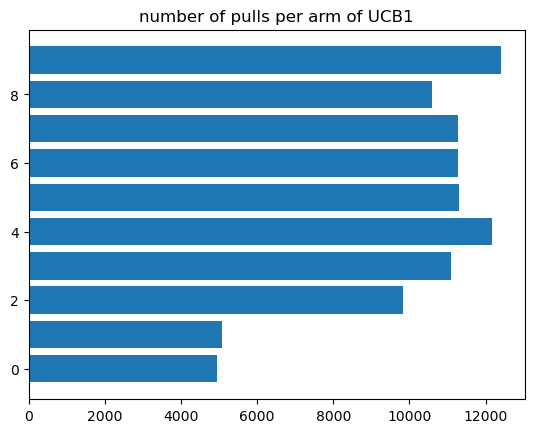

In [118]:
plt.barh(y=np.arange(number_rhos), width=my_agent.N_pulls)
plt.title('number of pulls per arm of UCB1')

### simulation

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import math

np.random.seed(18)

# environmental settings
n_rounds= 1000

# opponents' fixed parameters
n_adv = 4 # four opponents
ctrs = np.ones(n_adv).tolist()
other_bids = np.random.uniform(0, 1, size = (n_adv, n_rounds))
# other_bids = np.random.choice([0.25, 0.5, 0.75, 1], (n_adv, n_rounds))
m_t = other_bids.max(axis=0)

# my parameters
my_value = 0.8
my_ctr = 1
B = n_rounds*my_value/10 # 80
ctrs.append(my_ctr)


# fixed agent
# my_agent = FixedBiddingAgent(my_value)

# multiplicative pace agent
eta = 1/math.sqrt(n_rounds) # from theory
my_agent = ContinuousUpdatedRhoMPAgent(valuation=my_value,
                                  budget=B,
                                  T=n_rounds, 
                                  eta=eta)


auction = SecondPriceAuction(ctrs)

utilities = []
my_bids = []
my_payments = []
total_wins = 0


for u in range(n_rounds):
    # interaction
    my_bid = round(my_agent.bid(),2)
    bids = np.append(other_bids[:, u].ravel(), my_bid)
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==n_adv)
    f_t, c_t = (my_value-payments_per_click)*my_win, payments_per_click*my_win
    my_agent.update(f_t, c_t)
    # logging
    # if(my_win):
        # print(f'# Round {u}')
        # print(f'chosen rho={my_agent.used_rho}, my bid = {my_bid}, left budget={my_agent.budget}, lambda={my_agent.lmbds}')

    utilities.append(f_t)
    my_bids.append(my_bid)
    my_payments.append(c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')


Total # of Wins: 156


#### plot

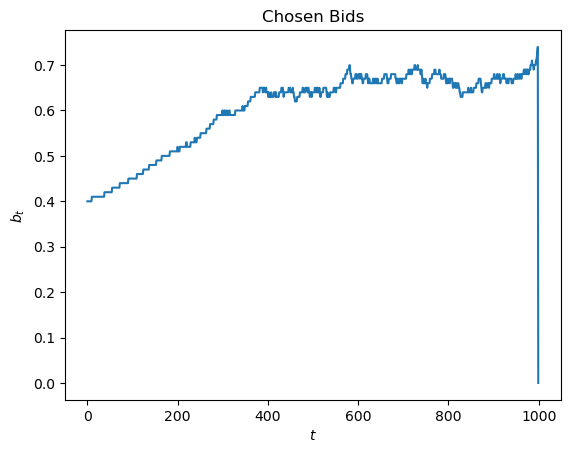

In [120]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

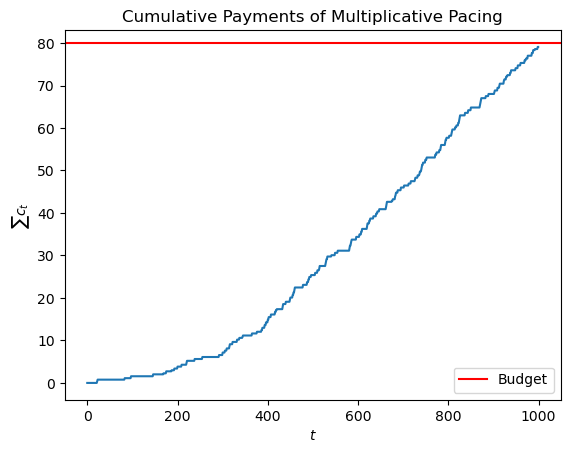

In [121]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

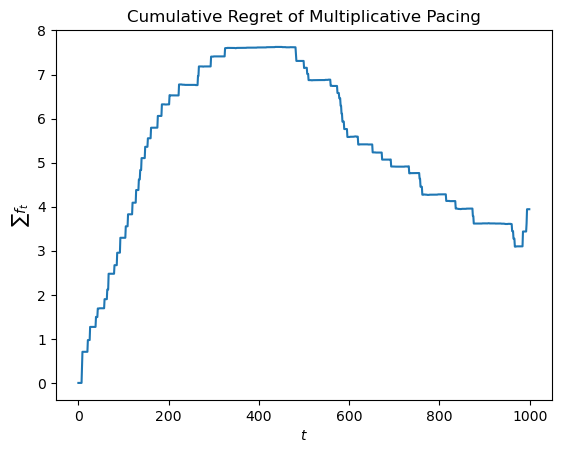

In [124]:
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_value, m_t, n_rounds)

cumulative_regret = np.cumsum(clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

## Compound Poisson simulation

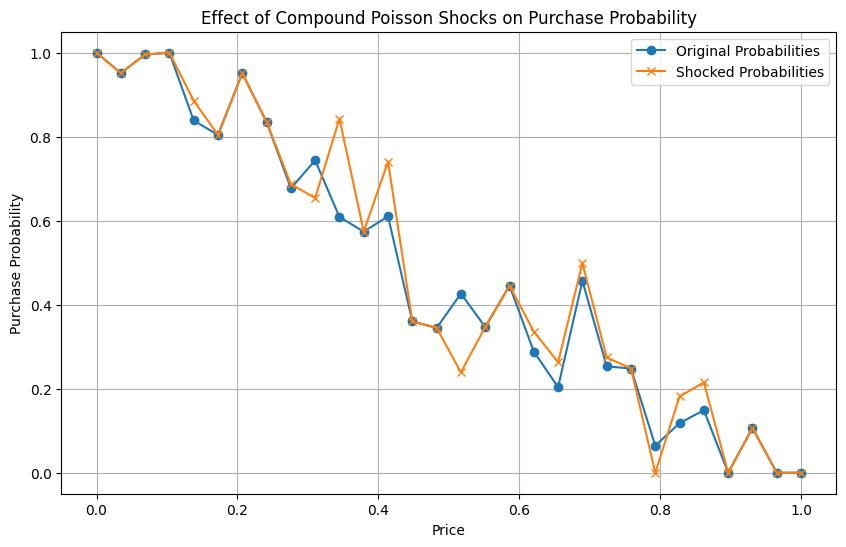

In [ ]:
class PricingEnvironment:
    def __init__(self, max_price=1.0, noise_level=0.1, model='linear', lambda_rate=1, shock_mean=0, shock_std=0.05):
        self.max_price = max_price
        self.noise_level = noise_level
        self.model = model
        self.lambda_rate = lambda_rate
        self.shock_mean = shock_mean
        self.shock_std = shock_std
        np.random.seed(42)

    def generate_data(self, n_points=100, apply_shocks=True):
        prices = np.linspace(0, self.max_price, n_points)
        
        if self.model == 'linear':
            beta_0 = 1
            beta_1 = -1
            purchase_probabilities = beta_0 + beta_1 * prices
            
        elif self.model == 'logit':
            alpha = 0
            beta = -5
            purchase_probabilities = 1 / (1 + np.exp(-(alpha + beta * prices)))
            
        elif self.model == 'probit':
            alpha = 0
            beta = -5
            purchase_probabilities = norm.cdf(alpha + beta * prices)
            
        elif self.model == 'KERNEL':
            purchase_probabilities = np.abs(np.sin(2 * np.pi * prices) * np.exp(-prices * 5) + prices * .10) + .1

        noisy_purchase_probabilities = purchase_probabilities + np.random.normal(0, self.noise_level, n_points)
        noisy_purchase_probabilities = np.clip(noisy_purchase_probabilities, 0, 1)
        
        shocked_probabilities = noisy_purchase_probabilities.copy()
        
        if apply_shocks:
            shocked_probabilities = self.apply_compound_poisson_shocks(shocked_probabilities)

        return prices, noisy_purchase_probabilities, shocked_probabilities

    def apply_compound_poisson_shocks(self, probabilities):
        """
            Simulate random days with market shocks with a different shock strength.

            Parameters:
            - n_days: The number of days to simulate.
            - lambda_rate: The average number of jumps per day.
            - shock_std: std of jump sizes
            - shock_mean: mean of jump sizes

            Returns:
            - The actual probabilities we want to work wirk
        """
        n_days = len(probabilities)
        n_shocks = np.random.poisson(self.lambda_rate * n_days)
        shock_days = np.random.choice(range(n_days), n_shocks, replace=False)
        
        shocks = np.random.normal(self.shock_mean, self.shock_std, n_shocks)
        
        for i, day in enumerate(shock_days):
            probabilities[day] += shocks[i]
            probabilities[day] = np.clip(probabilities[day], 0, 1)
        
        return probabilities
    
    def get_purchase_probability(self, price):
        if self.model == 'linear':
            beta_0 = 1
            beta_1 = -1
            purchase_probability = beta_0 + beta_1 * price
            
        elif self.model == 'logit':
            alpha = 0
            beta = -5
            purchase_probability = 1 / (1 + np.exp(-(alpha + beta * price)))
            
        elif self.model == 'probit':
            alpha = 0
            beta = -5
            purchase_probability = norm.cdf(alpha + beta * price)
            
        elif self.model == 'KERNEL':
            purchase_probability = np.abs(np.sin(2 * np.pi * price) * np.exp(-price * 5) + price * .10) + .1

        noisy_purchase_probability = purchase_probability + np.random.normal(0, self.noise_level)
        noisy_purchase_probability = np.clip(noisy_purchase_probability, 0, 1)
        
        return noisy_purchase_probability

# Generate data and plot
env = PricingEnvironment(lambda_rate=0.5, shock_mean=0.00, shock_std=0.1)
prices, original_probs, shocked_probs = env.generate_data(n_points=30)

plt.figure(figsize=(10, 6))
plt.plot(prices, original_probs, label='Original Probabilities', marker='o')
plt.plot(prices, shocked_probs, label='Shocked Probabilities', marker='x')
plt.xlabel('Price')
plt.ylabel('Purchase Probability')
plt.title('Effect of Compound Poisson Shocks on Purchase Probability')
plt.legend()
plt.grid(True)
plt.show()


### previous

In [71]:
import numpy as np
from scipy.stats import norm

class PricingEnvironment:
    def __init__(self, max_price=1.0, noise_level=0.1, model='linear'):
        self.max_price = max_price  # if max_price different from 0, need to normalize probabilities between [0,max_price]
        self.noise_level = noise_level
        self.model = model
        np.random.seed(42)

    def generate_data(self, n_points=100):
        # vector of n_points elements
        prices = np.linspace(0, self.max_price, n_points)
        
        if self.model == 'linear':
            beta_0 = 1
            beta_1 = -1
            purchase_probabilities = beta_0 + beta_1 * prices
            
        elif self.model == 'logit':
            alpha = 0
            beta = -5
            purchase_probabilities = 1 / (1 + np.exp(-(alpha + beta * prices)))
            
        elif self.model == 'probit':
            alpha = 0
            beta = -5
            purchase_probabilities = norm.cdf(alpha + beta * prices)
            
        elif self.model == 'KERNEL':
            purchase_probabilities = np.abs(np.sin(2 * np.pi * prices) * np.exp(-prices * 5) + prices * .10) + .1

        noisy_purchase_probabilities = purchase_probabilities + np.random.normal(0, self.noise_level, n_points)
        noisy_purchase_probabilities = np.clip(noisy_purchase_probabilities, 0, 1)
        
        return prices.reshape(-1, 1), noisy_purchase_probabilities
    
    def get_purchase_probability(self, price):
        """Return the purchase probability for a given price, incorporating noise."""
        if self.model == 'linear':
            beta_0 = 1
            beta_1 = -1
            purchase_probability = beta_0 + beta_1 * price
            
        elif self.model == 'logit':
            alpha = 0
            beta = -5
            purchase_probability = 1 / (1 + np.exp(-(alpha + beta * price)))
            
        elif self.model == 'probit':
            alpha = 0
            beta = -5
            purchase_probability = norm.cdf(alpha + beta * price)
            
        elif self.model == 'KERNEL':
            purchase_probability = np.abs(np.sin(2 * np.pi * price) * np.exp(-price * 5) + price * .10) + .1

        # Add noise
        noisy_purchase_probability = purchase_probability + np.random.normal(0, self.noise_level)
        
        # Ensure the probability is within [0, 1]
        noisy_purchase_probability = np.clip(noisy_purchase_probability, 0, 1)
        
        return noisy_purchase_probability


In [68]:
class GaussianProcessPricingAgent:
    def __init__(self, initial_data=None, initial_targets=None):
        """The kernel is RBF with white noise"""
        self.kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
        self.gp = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=40)
        
        # If the agent is initialized with some historical data, we will use it; otherwise, we will start empty
        self.X_train = np.array(initial_data if initial_data is not None else [])
        self.y_train = np.array(initial_targets if initial_targets is not None else [])
        
        # Fit the model if we have data
        if initial_data is not None and initial_targets is not None:
            self.gp.fit(self.X_train, self.y_train)
    
    def update_model(self, new_data, new_target):
        """Update the Gaussian Process model with new data (a price and its observed outcome)"""
        if self.X_train.size > 0:
            self.X_train = np.vstack((self.X_train, [new_data]))
            self.y_train = np.append(self.y_train, new_target)
        else:
            # This case handles the first update
            self.X_train = np.array([new_data])
            self.y_train = np.array([new_target])
        
        # Re-fit the Gaussian Process with the updated dataset
        self.gp.fit(self.X_train, self.y_train)
    
    def get_price(self):
        """Predicts the purchase probability across a range of prices and selects the optimal price"""
        # Define a range of prices to evaluate
        X_test = np.linspace(0, 1, 100).reshape(-1, 1)
        
        # Predict the outcome for each price in the range
        y_pred, sigma = self.gp.predict(X_test, return_std=True)
        
        # Select the price with the highest expected outcome - Chooses the price with the max predicted purchase probability
        optimal_price_index = np.argmax(y_pred)
        optimal_price = X_test[optimal_price_index]
        
        return optimal_price.item()  # Convert numpy array to scalar
    
    def plot(self, X_test, y_pred, sigma):
        """Utility method to visualize the Gaussian Process predictions"""
        plt.figure(figsize=(10, 5))
        plt.plot(self.X_train, self.y_train, 'r.', markersize=10, label='Observations')
        plt.plot(X_test, y_pred, 'b-', label='Prediction')
        plt.fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.2, color='blue')
        plt.xlabel('Price')
        plt.ylabel('Purchase Probability')
        plt.title('Gaussian Process Regression on Pricing Data with 95% CI')
        plt.legend()
        plt.show()

In [69]:
class BasicBiddingAgent:
    def __init__(self, initial_bid=0.5):
        self.current_bid = initial_bid

    def get_bid(self):
        # For now, it returns a fixed or randomly chosen bid.
        return self.current_bid

    def update_bid(self, auction_result, cost=None):
        # Placeholder for a learning mechanism to adjust bids over time.
        pass




Day 1
Pricing - Set price: 0.49, Purchase probability: 0.15
Bidding - Bid of 0.50 won the auction.

Day 2
Pricing - Set price: 0.53, Purchase probability: 0.13
Bidding - Bid of 0.50 did not win the auction.


c:\Mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



Day 3
Pricing - Set price: 0.37, Purchase probability: 0.28
Bidding - Bid of 0.50 won the auction.

Day 4
Pricing - Set price: 0.23, Purchase probability: 0.43
Bidding - Bid of 0.50 did not win the auction.

Day 5
Pricing - Set price: 0.00, Purchase probability: 0.15
Bidding - Bid of 0.50 did not win the auction.

Day 6
Pricing - Set price: 0.21, Purchase probability: 0.35
Bidding - Bid of 0.50 did not win the auction.

Day 7
Pricing - Set price: 0.24, Purchase probability: 0.44
Bidding - Bid of 0.50 won the auction.

Day 8
Pricing - Set price: 0.23, Purchase probability: 0.43
Bidding - Bid of 0.50 did not win the auction.

Day 9
Pricing - Set price: 0.27, Purchase probability: 0.35
Bidding - Bid of 0.50 won the auction.

Day 10
Pricing - Set price: 0.23, Purchase probability: 0.42
Bidding - Bid of 0.50 did not win the auction.

Day 11
Pricing - Set price: 0.24, Purchase probability: 0.36
Bidding - Bid of 0.50 did not win the auction.

Day 12
Pricing - Set price: 0.22, Purchase probab

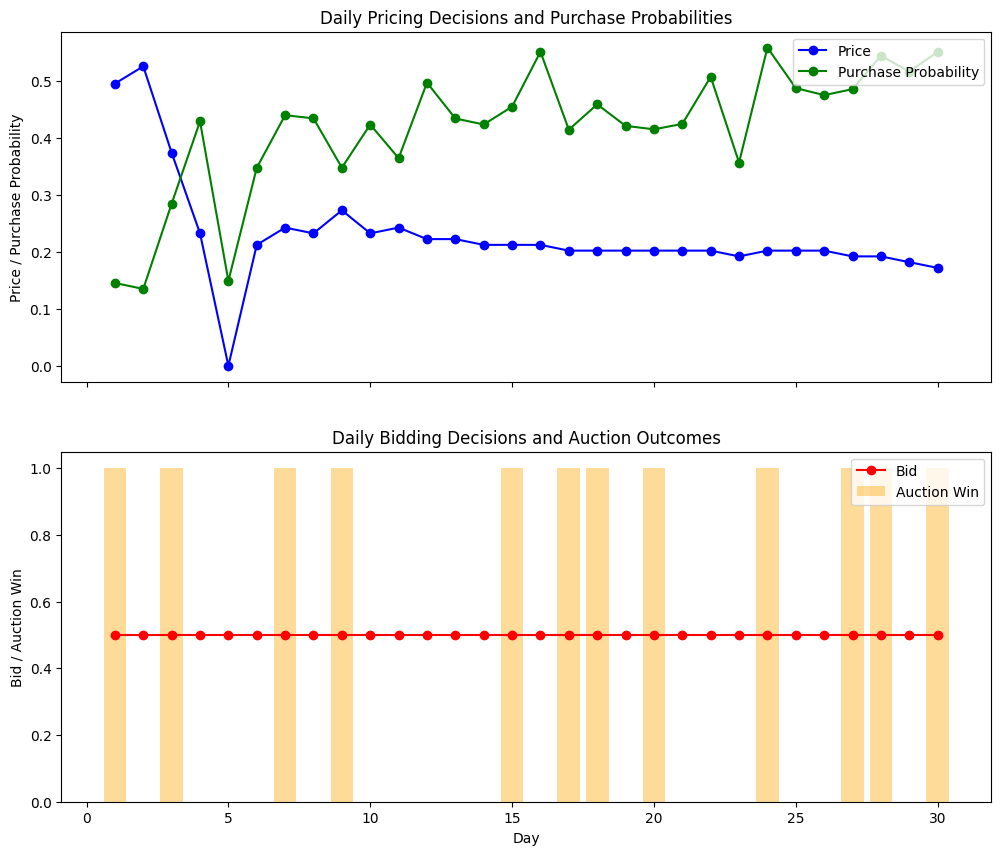

In [72]:
# Initialize the pricing environment and agents
env = PricingEnvironment(model='logit', noise_level=0.05)
env = PricingEnvironment(model='KERNEL', noise_level=0.05)
pricing_agent = GaussianProcessPricingAgent(initial_data=[[0.5]], initial_targets=[env.get_purchase_probability(0.5)])
bidding_agent = BasicBiddingAgent(initial_bid=0.5)

n_days = 30  # Number of days to simulate

# Lists to store simulation outcomes
prices = []
purchase_probs = []
bids = []
auction_wins = []

# Simulation loop
for day in range(1, n_days + 1):

    price = pricing_agent.get_price()
    print(f"\nDay {day}")    
    # Obtain purchase probability for the set price
    purchase_probability = env.get_purchase_probability(price)
    print(f"Pricing - Set price: {price:.2f}, Purchase probability: {purchase_probability:.2f}")

    
    # Bidding strategy
    bid = bidding_agent.get_bid()
    auction_win = np.random.rand() < 0.5  # Simulated auction outcome
    if auction_win:
        print(f"Bidding - Bid of {bid:.2f} won the auction.")
    else:
        print(f"Bidding - Bid of {bid:.2f} did not win the auction.")
    
    # Update the pricing model based on the day's sales outcomes
    sales_outcome = purchase_probability  # WILL NEED TO EDIT THIS SOMEHOW !!!!!!!!!!!!!!!!!!!!!
    pricing_agent.update_model(new_data=[price], new_target=sales_outcome)
    bidding_agent.update_bid(auction_result=auction_win)
    
    # Store the outcomes for plotting
    prices.append(price)
    purchase_probs.append(purchase_probability)
    bids.append(bid)
    auction_wins.append(auction_win)

# Convert auction wins to a numeric format for plotting
auction_wins_numeric = [1 if win else 0 for win in auction_wins]

days = list(range(1, n_days + 1))

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot pricing decisions and outcomes
axs[0].plot(days, prices, '-o', label='Price', color='blue')
axs[0].plot(days, purchase_probs, '-o', label='Purchase Probability', color='green')
axs[0].set_title('Daily Pricing Decisions and Purchase Probabilities')
axs[0].set_ylabel('Price / Purchase Probability')
axs[0].legend(loc='upper right')

# Plot bidding decisions and outcomes
axs[1].plot(days, bids, '-o', label='Bid', color='red')
axs[1].bar(days, auction_wins_numeric, color='orange', alpha=0.4, label='Auction Win')
axs[1].set_title('Daily Bidding Decisions and Auction Outcomes')
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Bid / Auction Win')
axs[1].legend(loc='upper right')

plt.show()
